In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

torch.manual_seed(0)

In [35]:
col_desc = {
    'AGYSUB': 'Agency',
    'LOC': 'Location',
    'AGELVL': 'Age (bucket)',
    'EDLVL': 'Education level',
    'GSEGRD': 'General schedule & Equivalent grade',
    'LOSLVL': 'Length of service (bucket)',
    'OCC': 'Occupation',
    'PATCO': 'Occupation category',
    'PPGRD': 'Pay Plan & Grade',
    'STEMOCC': 'STEM Occupation',
    'SUPERVIS': 'Supervisory status',
    'TOA': 'Type of appointment',
    'WORKSCH': 'Work schedule',
    'WORKSTAT': 'Work status',
    'LOS': 'Average length of service',
}

In [2]:
data_path    = Path('../data/')
model_folder = Path('../models/')
model_path   = model_folder / 'edlvl_clf_salary_bucket.pt'
df           = pd.read_csv(data_path / 'interim' / 'fed_emp.csv')
emb_dim      = 10

In [3]:
# Removing the nan values in columns by either adding a new category
# or dropping the lines
df                                   = df[~df.EDLVL.isnull()]
df.loc[df.GSEGRD.isnull(), 'GSEGRD'] = 0
df.loc[df.OCC.isnull(), 'OCC']       = 0
df                                   = df[~df.SUPERVIS.isnull()]
df                                   = df[~df.TOA.isnull()]
df                                   = df[~df.SALARY.isnull()]
df                                   = df[~df.LOS.isnull()]
# Target generation, we partition the salary values in 10 equally sized
# buckets.
df['SALBUCKET']                      = pd.qcut(df.SALARY, np.arange(0, 1.1, .1))
# df.isnull().sum(axis = 0)

In [4]:
df = df.sample(30000)

In [5]:
df_data    = df.drop(['SALBUCKET', 'SALARY', 'SALLVL'], axis = 1)
df_target  = df['SALBUCKET']

In [6]:
numerical_columns = ['LOS']
df_num            = df_data[numerical_columns]
num_val_mean      = df_num.mean(axis = 0)
num_val_std       = df_num.std(axis = 0)
df_num            = (df_num - num_val_mean) / num_val_std
df_cat            = df_data.drop(numerical_columns, axis = 1) 

In [7]:
columns_encoders = {
    col : {
        val : i 
        for i, val in enumerate(df[col].unique())
    }
    for col in df_cat.columns
}
target_encoder = {
    val : i 
    for i, val in enumerate(sorted(df_target.unique()))
}
column_order = sorted(columns_encoders.keys())

In [8]:
for col in df_cat.columns:
    df_cat[col] = df_cat[col].apply(lambda x: columns_encoders[col][x])
df_target = df_target.map(lambda x: target_encoder[x])

In [9]:
class CategoricalEmbeddings(nn.Module):
    def __init__(self, col_order, col_encoders, col_to_emb_dim):
        super(CategoricalEmbeddings, self).__init__()
        self.col_order = col_order 
        self.cat_embs  = nn.ModuleDict({
            col: nn.Embedding(len(col_encoders[col]), col_to_emb_dim[col])
            for col in col_order
        })
        
    def forward(self, cat_variables):
        embeddings = [self.cat_embs[col](cat_variables[col]) for col in self.col_order]
        
        return torch.cat(embeddings, dim = 1)

In [10]:
class EdlvlClassifier(nn.Module):
    def __init__(self, col_order, col_encoders, col_to_emb_dim, class_number, num_var_number, 
                 lin_size = 256, dropout_rate = 0.):
        super(EdlvlClassifier, self).__init__()
        self.cat_emb    = CategoricalEmbeddings(col_order, col_encoders, col_to_emb_dim)
        sum_cat_emb_dim = sum(col_to_emb_dim.values())
        self.linear1    = nn.Linear(sum_cat_emb_dim + num_var_number, lin_size)
        self.linear2    = nn.Linear(lin_size, class_number)
        self.dropout    = nn.Dropout(dropout_rate)
        
    def forward(self, cat_variables, num_variables):
        cat_embeddings = self.cat_emb(cat_variables)
        cat_num_tensor = torch.cat([cat_embeddings, num_variables], dim = 1)
        cat_num_tensor = self.dropout(cat_num_tensor)
        out_linear1    = F.relu(self.dropout(self.linear1(cat_num_tensor)))
        out_linear2    = self.linear2(out_linear1)
        
        return out_linear2

In [11]:
model = EdlvlClassifier(
    column_order,
    columns_encoders,
    {
        col : emb_dim
        for col in columns_encoders
    },
    len(target_encoder),
    num_var_number = df_num.shape[1]
)
model

EdlvlClassifier(
  (cat_emb): CategoricalEmbeddings(
    (cat_embs): ModuleDict(
      (AGELVL): Embedding(11, 10)
      (AGYSUB): Embedding(419, 10)
      (EDLVL): Embedding(22, 10)
      (GSEGRD): Embedding(16, 10)
      (LOC): Embedding(106, 10)
      (LOSLVL): Embedding(10, 10)
      (OCC): Embedding(544, 10)
      (PATCO): Embedding(7, 10)
      (PPGRD): Embedding(544, 10)
      (STEMOCC): Embedding(94, 10)
      (SUPERVIS): Embedding(6, 10)
      (TOA): Embedding(18, 10)
      (WORKSCH): Embedding(8, 10)
      (WORKSTAT): Embedding(2, 10)
    )
  )
  (linear1): Linear(in_features=141, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.0)
)

In [12]:
dataset = TensorDataset(
    *[
        torch.tensor(df_cat[col].values)
        for col in column_order
    ], # categorical variables in the correct order
    torch.tensor(df_num.values, dtype = torch.float32), # numerical variables
    torch.tensor(df_target.values, dtype = torch.int64) # target variables
)

In [13]:
dataset_size                 = len(dataset)
valid_prop                   = 0.2
valid_size                   = round(valid_prop * dataset_size)
lengths                      = [dataset_size - valid_size, valid_size]
train_dataset, valid_dataset = random_split(dataset, lengths)

In [14]:
train        = True
device       = torch.device('cuda')
model        = model.to(device)
epochs       = 50
batch_size   = 2048
optimizer    = optim.Adam(model.parameters())
criterion    = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)

In [15]:
if train:
    for epoch in range(epochs):
        correct = 0
        total   = 0
        for i, (*cat_var_list, num_var, y) in enumerate(train_loader):
            optimizer.zero_grad()
            cat_var_list   = [t.to(device) for t in cat_var_list]
            num_var        = num_var.to(device)
            y              = y.to(device)
            cat_variables  = dict(zip(column_order, cat_var_list))
            res            = model(cat_variables, num_var)
            loss           = criterion(res, y)
            correct       += (res.argmax(dim = 1) == y).detach().sum().item()
            total         += y.shape[0]
            loss.backward()
            optimizer.step()
            if i % 50 == 0:
                print(f'[{epoch}:{i}] {loss.item()}')
        model.eval()
        valid_correct = 0
        valid_total   = 0
        with torch.no_grad():
            for *cat_var_list, num_var, y in valid_loader:
                cat_var_list   = [t.to(device) for t in cat_var_list]
                num_var        = num_var.to(device)
                y              = y.to(device)
                cat_variables  = dict(zip(column_order, cat_var_list))
                res            = model(cat_variables, num_var)
                valid_correct += (res.argmax(dim = 1) == y).detach().sum().item()
                valid_total   += y.shape[0]
        print(valid_correct, valid_total)
        print(f'[{epoch}:{i}] [T] {100. * correct / total:5.2f}%, [V] {100. * valid_correct / valid_total:5.2f}% {loss.item():5.2f}')
        model.train()

    torch.save(model.state_dict(), model_path)

[0:0] 2.3556458950042725
2484 6000
[0:11] [T] 28.16%, [V] 41.40%  1.92
[1:0] 1.8851956129074097
2702 6000
[1:11] [T] 43.13%, [V] 45.03%  1.52
[2:0] 1.488377571105957
2794 6000
[2:11] [T] 45.99%, [V] 46.57%  1.31
[3:0] 1.3482788801193237
2930 6000
[3:11] [T] 47.76%, [V] 48.83%  1.26
[4:0] 1.2421553134918213
2978 6000
[4:11] [T] 50.45%, [V] 49.63%  1.19
[5:0] 1.2118233442306519
3046 6000
[5:11] [T] 51.99%, [V] 50.77%  1.20
[6:0] 1.1856889724731445
3094 6000
[6:11] [T] 52.90%, [V] 51.57%  1.16
[7:0] 1.1284633874893188
3157 6000
[7:11] [T] 54.40%, [V] 52.62%  1.07
[8:0] 1.0662353038787842
3212 6000
[8:11] [T] 55.24%, [V] 53.53%  1.09
[9:0] 1.1077712774276733
3228 6000
[9:11] [T] 56.14%, [V] 53.80%  1.07
[10:0] 1.0762945413589478
3249 6000
[10:11] [T] 57.20%, [V] 54.15%  1.06
[11:0] 1.0487762689590454
3282 6000
[11:11] [T] 57.87%, [V] 54.70%  1.05
[12:0] 1.0371980667114258
3324 6000
[12:11] [T] 58.55%, [V] 55.40%  1.07
[13:0] 1.0269312858581543
3375 6000
[13:11] [T] 59.06%, [V] 56.25%  1.03

In [16]:
model = EdlvlClassifier(
    column_order,
    columns_encoders,
    {
        col : emb_dim
        for col in columns_encoders
    },
    len(target_encoder),
    num_var_number = df_num.shape[1]

).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
valid_correct = 0
valid_total   = 0
with torch.no_grad():
    for *cat_var_list, num_var, y in valid_loader:
        cat_var_list   = [t.to(device) for t in cat_var_list]
        num_var        = num_var.to(device)
        y              = y.to(device)
        cat_variables  = dict(zip(column_order, cat_var_list))
        res            = model(cat_variables, num_var)
        valid_correct += (res.argmax(dim = 1) == y).detach().sum().item()
        valid_total   += y.shape[0]
print(valid_correct / valid_total)

0.6076666666666667


In [17]:
# sample_idx = 20

In [18]:
# *cat_var_list, num_var, y = train_dataset[sample_idx]
# cat_var_list   = [t.to(device) for t in cat_var_list]
# num_var        = num_var.to(device)
# y              = y.to(device)
# cat_variables  = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
# res            = model(cat_variables, num_var.unsqueeze(0))
# print(res.argmax(dim = 1).item(), y.item())

In [19]:
# def plot(index, res, x_label, correct_index = None):
#     fig, ax = plt.subplots(figsize = (15, 10))
#     bar_width = .70
#     if correct_index is None:
#         ax.bar(index, res, bar_width)
#     else:
#         barlist = ax.bar(index, res, bar_width)
#         barlist[correct_index].set_color('r')
#     ax.set_xticks(index)
#     ax.set_xticklabels(index)
#     ax.set_title(f'Prediction confidence by {x_label} on a specific sample')
#     ax.set_xlabel(x_label)
#     ax.set_ylabel('Confidence')
    
# plot(np.arange(len(res[0])), torch.softmax(res, dim = 1).detach().cpu().numpy()[0], 'pred_class', y.item())

In [20]:
# *cat_var_list, num_var, y = train_dataset[sample_idx]
# cat_var_list   = [t.to(device) for t in cat_var_list]
# num_var        = num_var.to(device)
# y              = y.to(device)
# cat_variables  = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
# res            = model(cat_variables, num_var.unsqueeze(0))
# print(y.item(), res.argmax(dim = 1).item())
# print(cat_variables)

In [21]:
# *cat_var_list, num_var, y = train_dataset[sample_idx]
# cat_var_list   = [t.to(device) for t in cat_var_list]
# num_var        = num_var.to(device)
# y              = y.to(device)
# cat_variables  = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
# orig_age_lvl   = cat_variables['AGELVL'].item()
# confidences = []
# age_lvls = list(range(12))
# for age_lvl in age_lvls:
#     cat_variables['AGELVL'][0] = age_lvl
#     res = model(cat_variables, num_var.unsqueeze(0))
#     res = torch.softmax(res, dim = 1)
#     confidences.append(res[0, y].item())

# plot(age_lvls, confidences, 'AGELVL', orig_age_lvl)

In [36]:
def plot_both_figures(sample_idx, col, bar_width = 0.7, figsize = (25, 12)):
    *cat_var_list, num_var, y = train_dataset[sample_idx]
    cat_var_list              = [t.to(device) for t in cat_var_list]
    num_var                   = num_var.to(device)
    y                         = y.to(device)
    cat_variables             = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
    pred                      = model(cat_variables, num_var.unsqueeze(0))
    print(f'target: {y.item()}, model pred: {pred.argmax(dim = 1).item()}')
    orig_col_value            = cat_variables[col].item()
    confidences               = []
    col_values                = list(range(len(df[col].unique())))
    print(cat_variables)
    for col_val in col_values:
        cat_variables[col][0] = col_val
        res = model(cat_variables, num_var.unsqueeze(0))
        res = torch.softmax(res, dim = 1)
        confidences.append(res[0, y].item())
    
    fig, ax = plt.subplots(
        nrows = 1, 
        ncols = 2, 
        figsize = figsize
    )
    class_index = list(range(len(df_target.unique())))
    ax[0].set_xticks(class_index)
    ax[0].set_xticklabels(class_index)
    barlist = ax[0].bar(class_index, torch.softmax(pred, dim = 1).detach().cpu().numpy()[0], bar_width)
    barlist[y.item()].set_color('r')
    ax[0].set_title(f'Model prediction confidence by class')
    ax[0].set_xlabel('Class')
    ax[0].set_ylabel('Confidence')
    
    ax[1].set_xticks(col_values)
    ax[1].set_xticklabels(col_values)
    barlist = ax[1].bar(col_values, confidences, bar_width)
    barlist[orig_col_value].set_color('r')
    ax[1].set_title(f'Model prediction confidence while varying a column')
    ax[1].set_xlabel(col_desc[col])
    ax[1].set_ylabel('Confidence')

target: 8, model pred: 8
{'AGELVL': tensor([1], device='cuda:0'), 'AGYSUB': tensor([9], device='cuda:0'), 'EDLVL': tensor([5], device='cuda:0'), 'GSEGRD': tensor([7], device='cuda:0'), 'LOC': tensor([10], device='cuda:0'), 'LOSLVL': tensor([2], device='cuda:0'), 'OCC': tensor([112], device='cuda:0'), 'PATCO': tensor([0], device='cuda:0'), 'PPGRD': tensor([14], device='cuda:0'), 'STEMOCC': tensor([22], device='cuda:0'), 'SUPERVIS': tensor([0], device='cuda:0'), 'TOA': tensor([5], device='cuda:0'), 'WORKSCH': tensor([0], device='cuda:0'), 'WORKSTAT': tensor([0], device='cuda:0')}


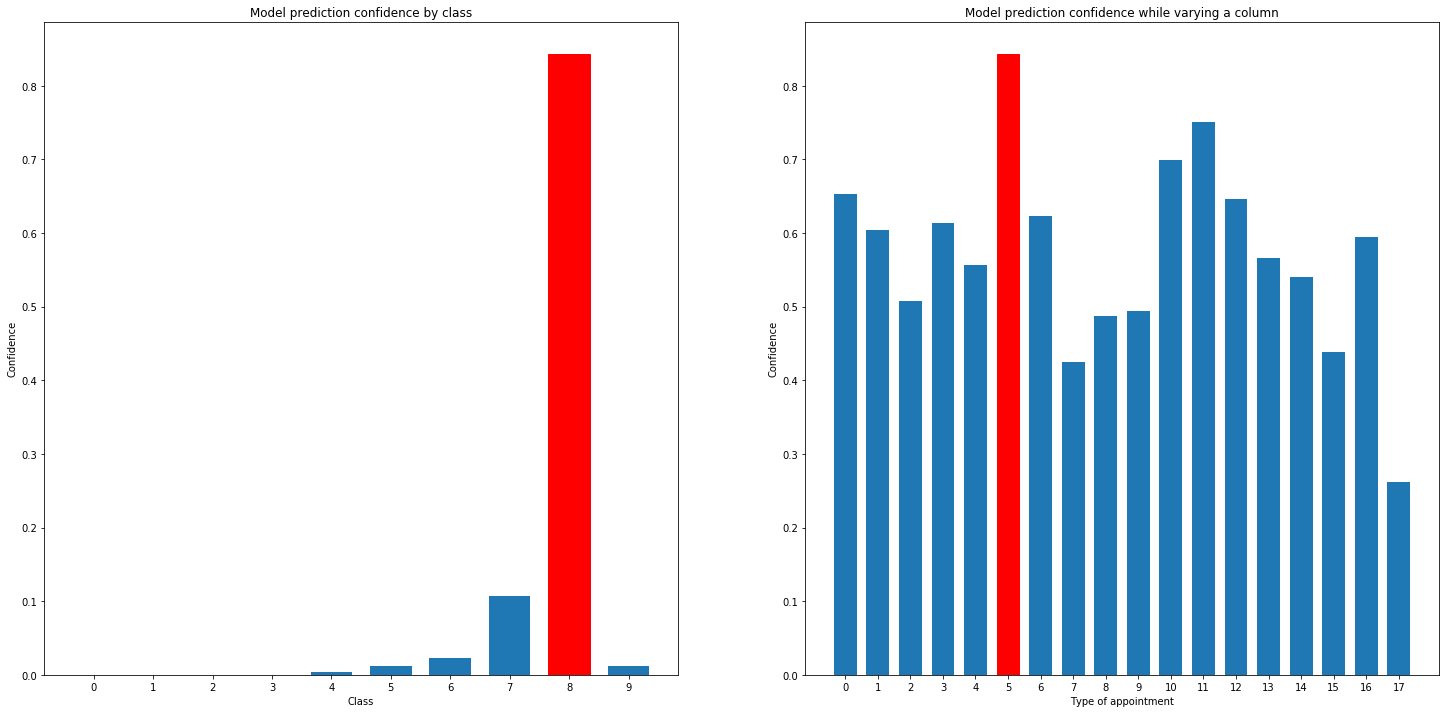

In [37]:
plot_both_figures(65, 'TOA')